In [1]:
import ipyparallel as ipp
n = 4
rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

In [2]:
%%px --block
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpi4py import MPI
import openpyxl
import copy
np.random.seed(482)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank, mpi.size))

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:2] MPI rank: 2/4


[stdout:3] MPI rank: 3/4


[stdout:1] MPI rank: 1/4


[stdout:0] MPI rank: 0/4


## Helper Functions

In [3]:
%%px --block
# Implement Custom Loss Function
@tf.function
def consensus_loss(y_true, y_pred, z, l2):
    
    # local error
    local_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    # consensus error
    consensus_loss = l2*tf.keras.losses.CategoricalCrossentropy()(z, y_pred)
        
    return local_loss + consensus_loss

In [4]:
 %%px --block
# Play around with this more
def set_learning_rate1(optimizer, epoch):
    if epoch <= 30:
        optimizer.lr = 0.0025
    if 30 < epoch <= 100:
        optimizer.lr = 0.0015
    elif 100 < epoch <= 200:
        optimizer.lr = 0.001
    elif 200 < epoch <= 300:
        optimizer.lr = 0.0005
    elif 300 < epoch <= 400:
        optimizer.lr = 0.00045
    elif 400 < epoch <= 450:
        optimizer.lr = 0.00005
    else:
        optimizer.lr = 0.00001

In [5]:
 %%px --block
# Play around with this more
def set_learning_rate2(optimizer, epoch):
    if epoch >= 1:
        optimizer.lr = optimizer.lr * tf.math.exp(-0.1)

In [6]:
%%px --block
def average_models(model, local_update, layer_shapes, layer_sizes):
    model_weights = model.get_weights()
    # flatten tensor weights
    coordinate_weights = flatten_weights(model_weights)
    local_weights = flatten_weights(local_update)
    next_weights = unflatten_weights(np.average([coordinate_weights, local_weights], axis=0),
                                           layer_shapes, layer_sizes)
    # update model weights to average
    model.set_weights(next_weights)

In [7]:
%%px --block
def get_model_architecture(model):
    # find shape and total elements for each layer of the resnet model
    model_weights = model.get_weights()
    layer_shapes = []
    layer_sizes = []
    for i in range(len(model_weights)):
        layer_shapes.append(model_weights[i].shape)
        layer_sizes.append(model_weights[i].size)
    return layer_shapes, layer_sizes

In [8]:
%%px --block
def flatten_weights(weight_list):
    return np.concatenate(list(weight_list[i].flatten() for i in range(len(weight_list))))

In [9]:
%%px --block
def unflatten_weights(flat_weights, layer_shapes, layer_sizes):
    unflatten_model = []
    start_idx = 0
    end_idx = 0
    for i in range(len(layer_shapes)):
        layer_size = layer_sizes[i]
        end_idx += layer_size
        unflatten_model.append(flat_weights[start_idx:end_idx].reshape(layer_shapes[i]))
        start_idx += layer_size
    return unflatten_model

In [13]:
%%px --block

def data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs):

    # read in CSV data
    # 13 min load time...
    raw_df_data = pd.read_excel("Data/CMU_SynTraffic_2022.xlsx")

    # add one-hot encoding of the sub-labels
    onehot = pd.get_dummies(raw_df_data['Application Type'])
    raw_df = pd.concat([raw_df_data, onehot], axis=1, join='inner')

    # label dataframe
    traffic_categories = raw_df['Traffic Type'].unique()
    tc = dict(zip(traffic_categories, range(len(traffic_categories))))
    class_attack = raw_df['Traffic Type'].map(lambda a: tc[a])
    raw_df['Traffic Type'] = class_attack

    # shuffle dataset
    raw_df = raw_df.sample(frac=1)

    # extract features
    non_normalized_df = raw_df.drop(['Application Type', 'Traffic Type', 'Data Source'], axis=1)

    # extract labels
    labels = raw_df['Traffic Type']

    # normalize the feature dataframe
    normalized_df = non_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # create coordination set
    coord_x = tf.convert_to_tensor(normalized_df.iloc[:coordination_size,:])
    coord_y = tf.convert_to_tensor(labels[:coordination_size])
    coordination_set = tf.data.Dataset.from_tensor_slices((coord_x,coord_y)).batch(coord_bs)

    # get data info
    num_inputs = len(normalized_df.columns.to_list())
    num_outputs = len(traffic_categories)
    
    # Split training data amongst workers
    worker_data = np.array_split(normalized_df.iloc[coordination_size:,:], size)[rank]
    worker_label = np.array_split(labels[coordination_size:], size)[rank]
    
    # create train/test split
    num_data = len(worker_label)
    num_train =  int(num_data * train_pct)
    # train
    train_x = tf.convert_to_tensor(worker_data.iloc[:num_train,:])
    train_y = tf.convert_to_tensor(worker_label[:num_train])
    train_set = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(train_bs)
    # test
    test_x = tf.convert_to_tensor(worker_data.iloc[num_train:,:])
    test_y = tf.convert_to_tensor(worker_label[num_train:])
    test_set = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(test_bs)
    
    # full training set
    full_train_data = tf.convert_to_tensor(normalized_df)
    full_train_label = tf.convert_to_tensor(labels)
    
    return train_set, test_set, coordination_set, full_train_data, full_train_label, num_inputs, num_outputs

In [14]:
%%px --block
def train(model, rank, size, lossF, optimizer, train_dataset, coordination_dataset, epochs, 
          coord_batch_size, batches, num_outputs, layer_shapes, layer_sizes, l2):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
        
    for epoch in range(epochs):
        
        # Adjust learning rate
        set_learning_rate2(optimizer, epoch)

        # Forward Pass of Coordination Set (get z)
        send_predicted = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        recv_avg_pred = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            pred = model(c_data, training=True)
            send_predicted[:, c_batch_idx] = pred.numpy().flatten()

        # Communication Process Here
        MPI.COMM_WORLD.Allreduce(send_predicted, recv_avg_pred, op=MPI.SUM)
        recv_avg_pred = recv_avg_pred/size

        # save initial model
        start_model = copy.deepcopy(model.get_weights())

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)

        # save model after local update
        local_model = copy.deepcopy(model.get_weights())

        # reset model weights
        model.set_weights(start_model)
        
        # Consensus Training
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            with tf.GradientTape() as tape:
                c_yp = model(c_data, training=True)
                loss_val = consensus_loss(y_true=c_target, y_pred=c_yp,
                                           z=recv_avg_pred[:, c_batch_idx].reshape(coord_batch_size, num_outputs),
                                           l2=l2)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # update model weights
        average_models(model, local_model, layer_shapes, layer_sizes)
        
        print('(Rank %d) Epoch %d: Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch, acc_metric.result(), \
                                                                                loss_metric.result()))
        loss_metric.reset_states()
        acc_metric.reset_states()

## Run Experiments

In [15]:
%%px --block
train_pct = 0.8
train_bs = 64
test_bs = 64
coord_bs = 32
coordination_size = coord_bs**2
coord_num_batches = int(np.ceil(coordination_size/coord_bs))

train_set, test_set, coord_set, full_train_x, full_train_y, num_inputs, num_outputs = data_pre_process(rank, size, train_pct, 
                                                                                                       train_bs, test_bs,
                                                                                                       coordination_size, 
                                                                                                       coord_bs)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:2] 2022-10-24 09:52:47.399731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:0] 2022-10-24 09:52:53.036993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:1] 2022-10-24 09:52:53.749370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:3] 2022-10-24 09:53:03.740065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
%%px --block
# multi classification model
if rank == 0 or rank == 1:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))
else:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))

# Initialize Local Loss Function
lossF = tf.keras.losses.SparseCategoricalCrossentropy()

# model architecture
layer_shapes, layer_sizes = get_model_architecture(multi_model)

# l2 penalty
l2 = 0.1

# epochs
epochs = 10

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [19]:
%%px --block
train(multi_model, rank, size, lossF, optimizer, train_set, 
      coord_set, epochs, coord_bs, coord_num_batches, num_outputs, layer_shapes, layer_sizes, l2)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] (Rank 0) Epoch 0: Training Accuracy is 0.8155, Loss is 0.4950
(Rank 0) Epoch 1: Training Accuracy is 0.8269, Loss is 0.4666
(Rank 0) Epoch 2: Training Accuracy is 0.8317, Loss is 0.4542
(Rank 0) Epoch 3: Training Accuracy is 0.8342, Loss is 0.4464
(Rank 0) Epoch 4: Training Accuracy is 0.8366, Loss is 0.4407
(Rank 0) Epoch 5: Training Accuracy is 0.8375, Loss is 0.4367
(Rank 0) Epoch 6: Training Accuracy is 0.8395, Loss is 0.4326
(Rank 0) Epoch 7: Training Accuracy is 0.8408, Loss is 0.4295
(Rank 0) Epoch 8: Training Accuracy is 0.8416, Loss is 0.4270
(Rank 0) Epoch 9: Training Accuracy is 0.8429, Loss is 0.4235


[stdout:1] (Rank 1) Epoch 0: Training Accuracy is 0.8143, Loss is 0.4942
(Rank 1) Epoch 1: Training Accuracy is 0.8278, Loss is 0.4631
(Rank 1) Epoch 2: Training Accuracy is 0.8325, Loss is 0.4502
(Rank 1) Epoch 3: Training Accuracy is 0.8349, Loss is 0.4428
(Rank 1) Epoch 4: Training Accuracy is 0.8366, Loss is 0.4378
(Rank 1) Epoch 5: Training Accuracy is 0.8389, Loss is 0.4329
(Rank 1) Epoch 6: Training Accuracy is 0.8398, Loss is 0.4288
(Rank 1) Epoch 7: Training Accuracy is 0.8412, Loss is 0.4262
(Rank 1) Epoch 8: Training Accuracy is 0.8419, Loss is 0.4229
(Rank 1) Epoch 9: Training Accuracy is 0.8432, Loss is 0.4201


[stdout:3] (Rank 3) Epoch 0: Training Accuracy is 0.8083, Loss is 0.5070
(Rank 3) Epoch 1: Training Accuracy is 0.8229, Loss is 0.4751
(Rank 3) Epoch 2: Training Accuracy is 0.8293, Loss is 0.4594
(Rank 3) Epoch 3: Training Accuracy is 0.8330, Loss is 0.4502
(Rank 3) Epoch 4: Training Accuracy is 0.8351, Loss is 0.4442
(Rank 3) Epoch 5: Training Accuracy is 0.8367, Loss is 0.4397
(Rank 3) Epoch 6: Training Accuracy is 0.8379, Loss is 0.4352
(Rank 3) Epoch 7: Training Accuracy is 0.8394, Loss is 0.4316
(Rank 3) Epoch 8: Training Accuracy is 0.8403, Loss is 0.4286
(Rank 3) Epoch 9: Training Accuracy is 0.8412, Loss is 0.4262


[stdout:2] (Rank 2) Epoch 0: Training Accuracy is 0.8101, Loss is 0.5076
(Rank 2) Epoch 1: Training Accuracy is 0.8255, Loss is 0.4718
(Rank 2) Epoch 2: Training Accuracy is 0.8320, Loss is 0.4580
(Rank 2) Epoch 3: Training Accuracy is 0.8346, Loss is 0.4497
(Rank 2) Epoch 4: Training Accuracy is 0.8365, Loss is 0.4435
(Rank 2) Epoch 5: Training Accuracy is 0.8379, Loss is 0.4388
(Rank 2) Epoch 6: Training Accuracy is 0.8393, Loss is 0.4344
(Rank 2) Epoch 7: Training Accuracy is 0.8406, Loss is 0.4302
(Rank 2) Epoch 8: Training Accuracy is 0.8416, Loss is 0.4271
(Rank 2) Epoch 9: Training Accuracy is 0.8425, Loss is 0.4242


In [20]:
%%px --block
predictions = multi_model.predict(full_train_x)

[stdout:1] 32768/32768 [==============================] - 53s 2ms/step


[stdout:3] 32768/32768 [==============================] - 54s 2ms/step


[stdout:2] 32768/32768 [==============================] - 54s 2ms/step


[stdout:0] 32768/32768 [==============================] - 53s 2ms/step


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [21]:
%%px --block
pred = tf.math.argmax(predictions, axis=1)
train_confusion_mtx = tf.math.confusion_matrix(full_train_y, pred)
# normalize confusion matrix
train_confusion_mtx = train_confusion_mtx / tf.reduce_sum(train_confusion_mtx, 0).numpy()
train_confusion_mtx = tf.where(tf.math.is_nan(train_confusion_mtx), tf.zeros_like(train_confusion_mtx), train_confusion_mtx)

[output:3]

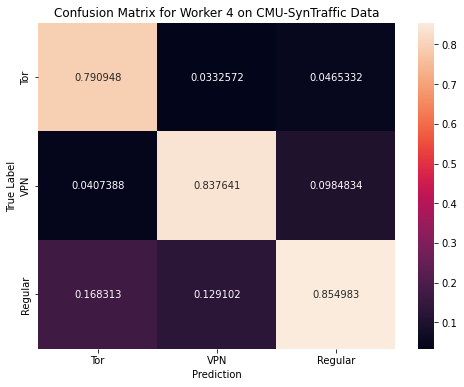

[output:2]

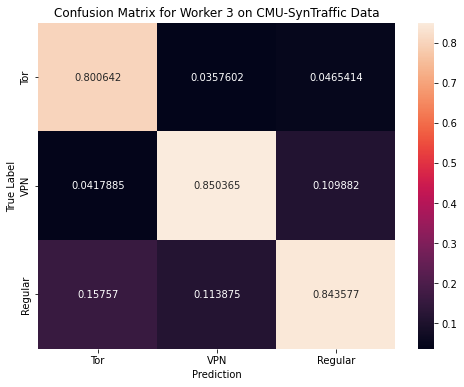

[output:1]

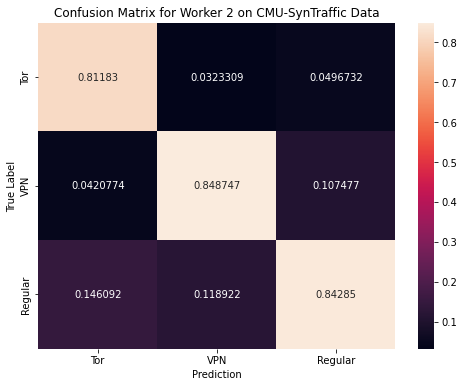

[output:0]

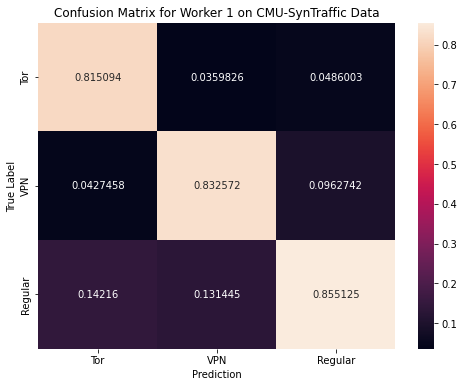

In [22]:
%%px --block
attack_labels = ['Tor', 'VPN', 'Regular']
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_mtx,
            xticklabels=attack_labels,
            yticklabels=attack_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Worker %d on CMU-SynTraffic Data' % (rank+1))
plt.show()

In [ ]:
'''
%%px --block

%%px --block
# read in CSV data
# 13 min load time...
raw_df_data = pd.read_excel("Data/CMU_SynTraffic_2022.xlsx")

train_pct = 0.8
train_bs = 64
test_bs = 64
coord_bs = 32
coordination_size = coord_bs**2
coord_num_batches = int(np.ceil(coordination_size/coord_bs))

# add one-hot encoding of the sub-labels
onehot = pd.get_dummies(raw_df_data['Application Type'])
raw_df = pd.concat([raw_df_data, onehot], axis=1, join='inner')

# label dataframe
traffic_categories = raw_df['Traffic Type'].unique()
tc = dict(zip(traffic_categories, range(len(traffic_categories))))
class_attack = raw_df['Traffic Type'].map(lambda a: tc[a])
raw_df['Traffic Type'] = class_attack

# shuffle dataset
raw_df = raw_df.sample(frac=1)

# extract features
non_normalized_df = raw_df.drop(['Application Type', 'Traffic Type', 'Data Source'], axis=1)

# extract labels
labels = raw_df['Traffic Type']

# normalize the feature dataframe
normalized_df = non_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# create coordination set
coord_x = tf.convert_to_tensor(normalized_df.iloc[:coordination_size,:])
coord_y = tf.convert_to_tensor(labels[:coordination_size])
coordination_set = tf.data.Dataset.from_tensor_slices((coord_x,coord_y)).batch(coord_bs)

# get data info
num_inputs = len(normalized_df.columns.to_list())
num_outputs = len(traffic_categories)

# Split training data amongst workers
worker_data = np.array_split(normalized_df.iloc[coordination_size:,:], size)[rank]
worker_label = np.array_split(labels[coordination_size:], size)[rank]

# create train/test split
num_data = len(worker_label)
num_train =  int(num_data * train_pct)
# train
train_x = tf.convert_to_tensor(worker_data.iloc[:num_train,:])
train_y = tf.convert_to_tensor(worker_label[:num_train])
train_set = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(train_bs)
# test
test_x = tf.convert_to_tensor(worker_data.iloc[num_train:,:])
test_y = tf.convert_to_tensor(worker_label[num_train:])
test_set = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(test_bs)

# full training set
full_train_data = tf.convert_to_tensor(normalized_df)
full_train_label = tf.convert_to_tensor(labels)
'''